In [17]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [18]:
h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()
gene_subset = ['protein_coding']
annot_ver = 'v40_cerberus'

In [19]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [20]:
df = pd.DataFrame()
df['gid'] = []
df['source'] = []
df['sector'] = []
for source in ['obs_major', 'obs_det']:
    temp = ca.triplets.loc[ca.triplets.source == source]
    temp = assign_gisx_sector(temp)
    temp = temp[['gid', 'source', 'sector']]
    df = df.merge(temp, how='outer', on='gid', suffixes=('', '_{}'.format(source)))

df.drop(['source', 'sector'], axis=1, inplace=True)

In [21]:
# # temp fix until I make sure I'm only considering isoforms >= 1 tpm in major set
# df = df.loc[~df.source_obs_det.isnull()]

In [22]:
df.loc[df.source_obs_det.isnull()]

,gid,source_obs_major,sector_obs_major,source_obs_det,sector_obs_det


In [23]:
# check to see where nan source_obs_dets are coming from
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df,
#                how='iso',
#                min_tpm=0)
# df.reset_index(inplace=True)
# beep = df.loc[df.annot_transcript_id.str.contains('ENSG00000285978')].set_index('annot_transcript_id').transpose()
# beep.loc[beep['ENSG00000285978[1,1,1]']>0]

In [24]:
# limit to gene subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=annot_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    df = df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    df = df.loc[df.biotype_category.isin(gene_subset)]
    df.drop('biotype_category', axis=1, inplace=True)

In [25]:
df.head()

,gid,source_obs_major,sector_obs_major,source_obs_det,sector_obs_det
0,ENSG00000000003,obs_major,tes,obs_det,tes
1,ENSG00000000005,obs_major,simple,obs_det,simple
2,ENSG00000000419,obs_major,mixed,obs_det,mixed
3,ENSG00000000457,obs_major,tes,obs_det,mixed
4,ENSG00000000460,obs_major,mixed,obs_det,mixed


In [26]:
df.drop(['source_obs_major', 'source_obs_det'], axis=1, inplace=True)
df = df.groupby(['sector_obs_major', 'sector_obs_det']).count().reset_index()

In [27]:
df.head()

,sector_obs_major,sector_obs_det,gid
0,mixed,mixed,6543
1,mixed,splicing,255
2,mixed,tes,608
3,mixed,tss,292
4,simple,mixed,247


{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


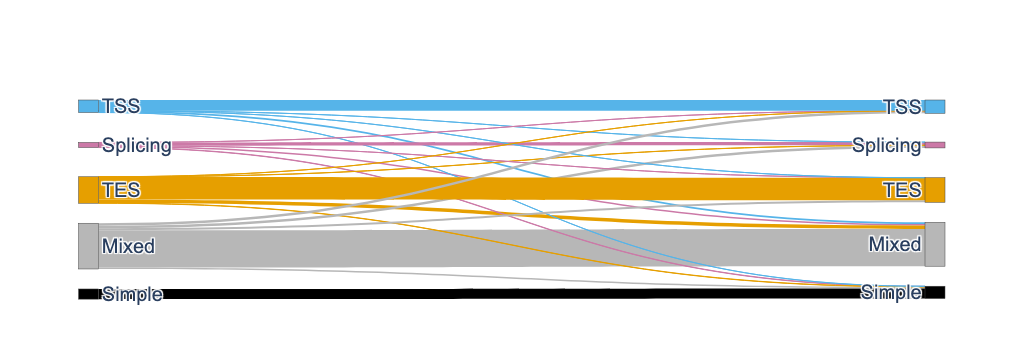

In [28]:
ofile = 'figures/obs_det_obs_major_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_det',
                  sink='sector_obs_major',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)

In [33]:
# what overall % are the same?
df['same'] = df.sector_obs_major == df.sector_obs_det
temp = df[['gid', 'same']].groupby('same').sum().reset_index()
n = temp.loc[temp.same == True, 'gid'].values[0]/temp.gid.sum()
print('{:.2f}% of protein coding genes are in the same sector b/w obs and obs major'.format(n*100))

83.91% of protein coding genes are in the same sector b/w obs and obs major


In [13]:
total_det = df[['sector_obs_det', 'gid']].groupby('sector_obs_det').sum().reset_index()
total_det.rename({'gid': 'total'}, axis=1, inplace=True)
total_det.head()

,sector_obs_det,total
0,mixed,8014
1,simple,1783
2,splicing,888
3,tes,4641
4,tss,2197


In [14]:
df[['sector_obs_major', 'gid']].groupby('sector_obs_major').sum().reset_index()


,sector_obs_major,gid
0,mixed,7698
1,simple,2162
2,splicing,1022
3,tes,4306
4,tss,2335


In [15]:
### df = df.merge(total_det, how='left', on='sector_obs_det')

In [16]:
df['perc'] = (df['gid']/df['total'])*100

KeyError: 'total'

In [ ]:
df.loc[df.sector_obs_major==df.sector_obs_det]

{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


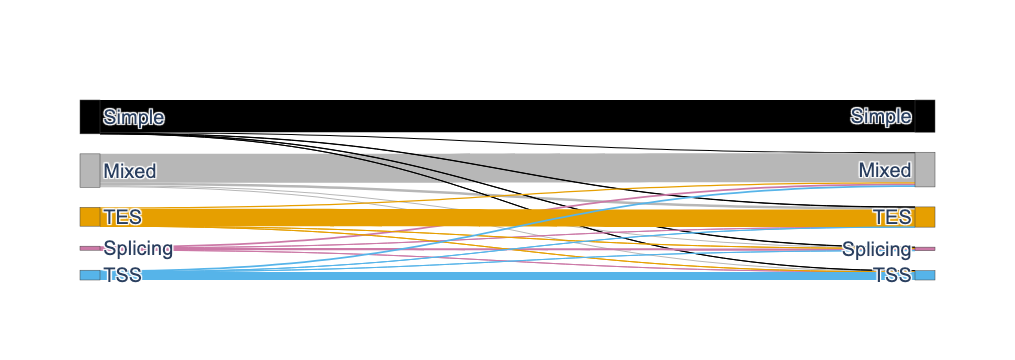

In [20]:
# what about the other way around?

ofile = 'figures/obs_major_obs_det_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_major',
                  sink='sector_obs_det',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)